In [2]:
import pandas as pd
import seaborn as sns
from scipy import signal
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np

In [3]:
mat = loadmat('data/S06.mat')
panel = pd.Panel(mat['data'])
''' Item axis: Epoch
    Major axis: Electrode
    Minor axis: Sample '''
panel

<class 'pandas.core.panel.Panel'>
Dimensions: 769 (items) x 256 (major_axis) x 201 (minor_axis)
Items axis: 0 to 768
Major_axis axis: 0 to 255
Minor_axis axis: 0 to 200

In [4]:
FREQ = 250 # Hz
ALPHA_RELEVANT_ELECTRODES = [8,44,80,131,185]

def plot_electrode(x):
    plt.plot(np.linspace(-200,600,201), x, alpha=0.5)

def plot_welch(x):
    f, power = signal.welch(x, fs=FREQ, nperseg=len(x), nfft=2048)
    plt.plot(f, power, '-')
    #plt.yscale('log')
    plt.xlim(-2,45)
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('PSD [V^2/Hz]')

# Un solo Epoch

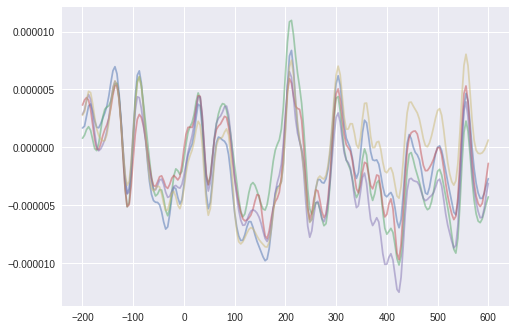

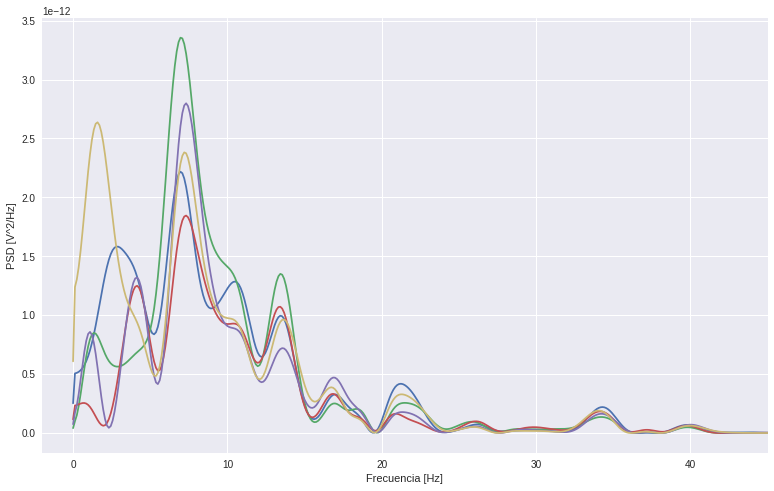

In [5]:
for electrode in ALPHA_RELEVANT_ELECTRODES:
    plot_electrode(panel[0,electrode])
plt.show()

plt.figure(figsize=(13, 8))
for electrode in ALPHA_RELEVANT_ELECTRODES:
    plot_welch(panel[0,electrode])
plt.show()

# Promedio entre Epochs

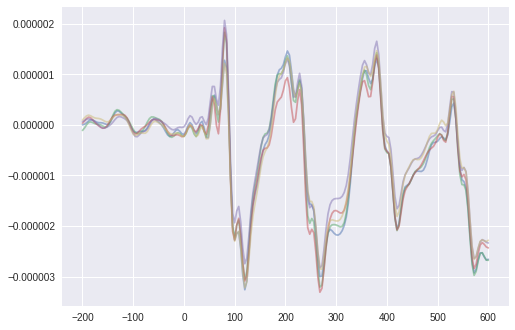

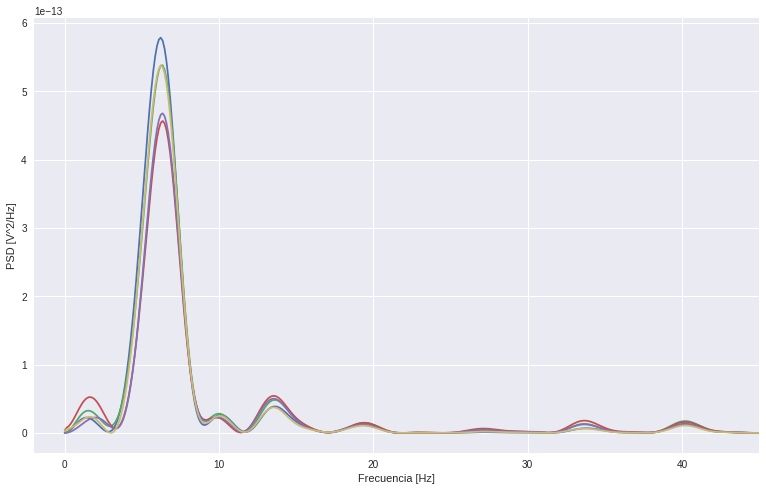

In [6]:
def mean_between_epochs(panel):
    return panel.mean(0)

mean_df = mean_between_epochs(panel).T

for electrode in ALPHA_RELEVANT_ELECTRODES:
    plot_electrode(mean_df[electrode])
plt.show()

plt.figure(figsize=(13, 8))
for electrode in ALPHA_RELEVANT_ELECTRODES:
    plot_welch(mean_df[electrode])
plt.show()


In [7]:
def mean_between_electrodes(panel, electrodes):
    return panel[:,electrodes].mean(1)

def fourier_per_epoch(panel, electrodes):
    samples_per_epoch = mean_between_electrodes(panel, electrodes)
    relevant_frecuencies = 38
    res = []
    for _, samples in samples_per_epoch.iteritems():
        frequencies, powers = signal.welch(samples, FREQ, nperseg=len(samples))
        res.append(powers[:relevant_frecuencies])
    return np.asarray(res), frequencies[:relevant_frecuencies]

spectrogram_alpha, frequencies_alpha = fourier_per_epoch(panel, ALPHA_RELEVANT_ELECTRODES)
#spectrogram_all, frequencies_all = fourier_per_epoch(panel, range(256))

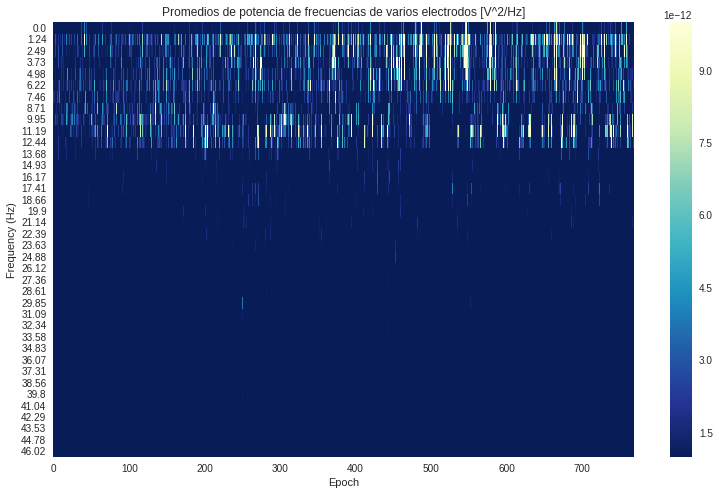

In [8]:
def plot_spectrogram(spectrogram, frequencies):
    spectrogram = spectrogram.T
    plt.figure(figsize=(13, 8))
    ax = sns.heatmap(spectrogram, 
                     xticklabels=100, yticklabels=frequencies.round(2), 
                     #cbar_kws=('PSD [V**2/Hz]'),
                     vmin=0.1e-11, vmax=1e-11, 
                     #center=1.5e-11,
                     cmap='YlGnBu_r'
                     )
    plt.title('Promedios de potencia de frecuencias de varios electrodos [V^2/Hz]')
    plt.xlabel('Epoch')
    plt.ylabel('Frequency (Hz)')
    plt.show()

plot_spectrogram(spectrogram_alpha, frequencies_alpha)

# Categorizamos las frecuencias según su tipo

In [9]:
def mean_power_per_frequency_range(panel):
    mean_samples = panel.mean(0).mean(0)

    def belongs(frequency_range, frequency):
        return frequency_range[0] <= frequency < frequency_range[1]

    frequencies, power = signal.welch(mean_samples, fs=FREQ, nperseg=len(mean_samples), nfft=2048)
    #plt.plot(frequencies, power)
    #plt.show()
    limits = {'delta': (0,4), 'tita': (4,8), 'alpha': (8,13), 'beta': (13,30), 'gamma': (30, 45)}
    values_by_range = {'delta':[], 'tita':[], 'alpha':[], 'beta':[], 'gamma':[]}

    for f, p in zip(frequencies, power):
        for key, limit in limits.items():
            if belongs(limit, f):
                values_by_range[key].append(p)

    return {key: np.mean(value) for key, value in values_by_range.items()}

In [10]:
import gc
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir('data') if (f.endswith('.mat') and f.startswith('S'))]

powers_per_frequency_range_S = []
df = {}
for filename in onlyfiles:
    mat = loadmat(join('data', filename))
    panel = pd.Panel(mat['data'])
    mean = mean_power_per_frequency_range(panel)
    df[filename, 'S'] = mean
    #mean['type'] = 'S'
    powers_per_frequency_range_S.append(mean)
    del mat
    del panel
    gc.collect()
pd.DataFrame(df)

,S01.mat,S02.mat,S03.mat,S04.mat,S05.mat,S06.mat,S07.mat,S08.mat,S09.mat,S10.mat
,S,S,S,S,S,S,S,S,S,S
alpha,1.018124e-18,1.490140e-18,3.298416e-18,3.461662e-18,4.216208e-19,2.214408e-18,3.606037e-18,2.307048e-17,2.336278e-15,1.288334e-18
beta,1.164993e-19,6.150669e-19,1.714577e-19,9.176014e-19,6.058410e-20,5.906103e-19,1.400770e-18,1.853513e-17,7.789290e-16,1.513935e-18
delta,1.758339e-17,4.480592e-18,4.069123e-18,9.619497e-17,2.192465e-18,2.657606e-18,9.885603e-16,2.531939e-16,9.199016e-15,2.850883e-17
gamma,4.287459e-20,6.511922e-20,2.125357e-20,4.421508e-19,5.533112e-21,1.763434e-19,4.491292e-19,3.741905e-18,1.790973e-16,7.233118e-19
tita,3.821427e-18,2.470559e-18,9.899706e-18,9.542269e-18,5.981990e-18,6.876186e-18,7.334120e-18,1.828888e-16,7.275962e-16,1.136760e-17


In [11]:
onlyfiles = [f for f in listdir('data') if (f.endswith('.mat') and f.startswith('P'))]
powers_per_frequency_range_P = []
df = {}
for filename in onlyfiles:
    mat = loadmat(join('data', filename))
    panel = pd.Panel(mat['data'])
    mean = mean_power_per_frequency_range(panel)
    #print(mean)
    df[filename,'P'] = mean
    #mean['type'] = 'P'
    powers_per_frequency_range_P.append(mean)
    del mat
    del panel
    gc.collect()
pd.DataFrame(df)

,P01.mat,P02.mat,P03.mat,P04.mat,P05.mat,P06.mat,P07.mat,P08.mat,P09.mat,P10.mat
,P,P,P,P,P,P,P,P,P,P
alpha,8.238155e-18,7.786535e-19,3.917995e-18,1.920496e-19,4.673913e-17,5.225773e-20,8.938046e-18,4.201974e-18,2.914532e-16,3.499935e-20
beta,1.398973e-18,5.133783e-19,7.829581e-19,2.822063e-20,1.468661e-17,1.921528e-20,3.662577e-18,9.701653e-19,5.726377e-16,1.000993e-20
delta,1.809511e-17,4.427606e-17,8.507534e-17,6.441223e-18,6.488753e-17,2.297620e-18,5.014396e-17,3.005454e-16,8.859136e-15,3.253238e-18
gamma,6.974721e-19,2.450367e-19,3.101347e-19,6.414734e-21,5.699224e-18,5.531395e-21,2.371531e-19,1.516745e-19,6.275231e-16,6.027917e-21
tita,7.506528e-17,2.009000e-17,6.656485e-18,3.035517e-18,3.245357e-16,4.929869e-19,8.393983e-17,1.213798e-16,2.482017e-15,2.987604e-19


(20, 5)
          alpha          beta         delta         gamma          tita
0  1.018124e-18  1.164993e-19  1.758339e-17  4.287459e-20  3.821427e-18
1  2.336278e-15  7.789290e-16  9.199016e-15  1.790973e-16  7.275962e-16
2  2.214408e-18  5.906103e-19  2.657606e-18  1.763434e-19  6.876186e-18
3  1.490140e-18  6.150669e-19  4.480592e-18  6.511922e-20  2.470559e-18
4  3.606037e-18  1.400770e-18  9.885603e-16  4.491292e-19  7.334120e-18
5  4.216208e-19  6.058410e-20  2.192465e-18  5.533112e-21  5.981990e-18
6  1.288334e-18  1.513935e-18  2.850883e-17  7.233118e-19  1.136760e-17
7  2.307048e-17  1.853513e-17  2.531939e-16  3.741905e-18  1.828888e-16
8  3.461662e-18  9.176014e-19  9.619497e-17  4.421508e-19  9.542269e-18
9  3.298416e-18  1.714577e-19  4.069123e-18  2.125357e-20  9.899706e-18
0  3.917995e-18  7.829581e-19  8.507534e-17  3.101347e-19  6.656485e-18
1  4.201974e-18  9.701653e-19  3.005454e-16  1.516745e-19  1.213798e-16
2  1.920496e-19  2.822063e-20  6.441223e-18  6.414734e-2

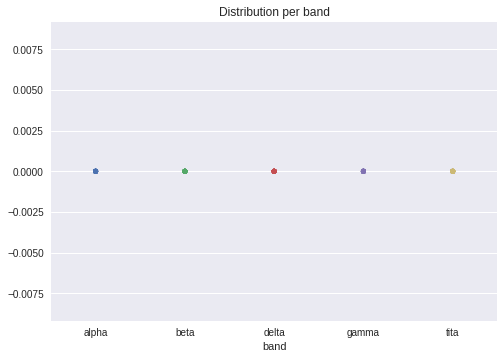

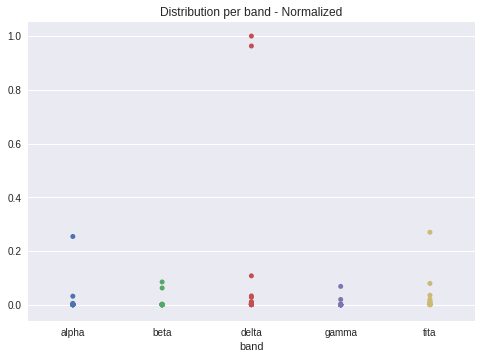

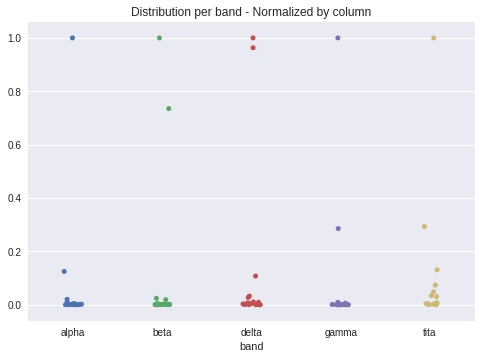

In [12]:
dS = pd.DataFrame(powers_per_frequency_range_S)
dP = pd.DataFrame(powers_per_frequency_range_P)
data = pd.concat([dS,dP])
print(data.shape)
print(data)

data = data.rename_axis("patient", axis=0)
data = data.rename_axis("band", axis=1)


ax = sns.stripplot(data=data, 
                   vmin=data.min().min(), 
                   vmax=data.max().max()
                  )
#ax.set_yscale('log')
plt.title('Distribution per band')
plt.show()

df = data
df_norm = (df - df.min().min()) / (df.max().max() - df.min().min())
ax = sns.stripplot(data=df_norm, 
                   vmin=df_norm.min(), 
                   vmax=df_norm.max() 
                  )
#ax.set_yscale('log')
plt.title('Distribution per band - Normalized')
plt.show()


df = data
df_norm = ( (df - df.min() ) / (df.max() - df.min()) )
ax = sns.stripplot(data=df_norm,
                   jitter=True,
                   vmin=df_norm.min().min(), 
                   vmax=df_norm.max().max() 
                  )
#ax.set_yscale('log')
plt.title('Distribution per band - Normalized by column')
plt.show()

# TODO: separar S y P en subcolumnas

## Realizamos todos los gráficos categóricos.
#### En ROJO los S, en AZUL los P.
Versión normalizados.

### Stripplot

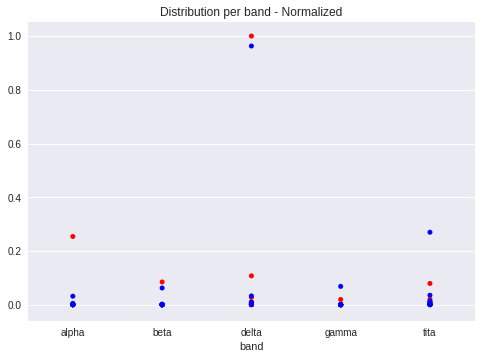

In [13]:
df_norm = (df - df.min().min()) / (df.max().max() - df.min().min())
ax = sns.stripplot(data=df_norm[:10],
                   color="r",
                   vmin=df_norm.min(), 
                   vmax=df_norm.max() 
                  )
ax = sns.stripplot(data=df_norm[10:],
                   color="b",
                   vmin=df_norm.min(), 
                   vmax=df_norm.max() 
                  )
#ax.set_yscale('log')
plt.title('Distribution per band - Normalized')
plt.show()

### Violin Plot

In [ ]:
df_norm = (df - df.min().min()) / (df.max().max() - df.min().min())
ax = sns.violinplot(data=df_norm[:10],
                   color="r",
                   vmin=df_norm.min(), 
                   vmax=df_norm.max() 
                  )
ax = sns.violinplot(data=df_norm[10:],
                   color="b",
                   vmin=df_norm.min(), 
                   vmax=df_norm.max() 
                  )
#ax.set_yscale('log')
plt.title('Distribution per band - Normalized')
plt.show()

### Bar Plot

In [ ]:
df_norm = (df - df.min().min()) / (df.max().max() - df.min().min())
ax = sns.barplot(data=df_norm[:10],
                   color="r",
                   vmin=df_norm.min(), 
                   vmax=df_norm.max() 
                  )
ax = sns.barplot(data=df_norm[10:],
                   color="b",
                   vmin=df_norm.min(), 
                   vmax=df_norm.max() 
                  )
#ax.set_yscale('log')
plt.title('Distribution per band - Normalized')
plt.show()

### SwarmPlot

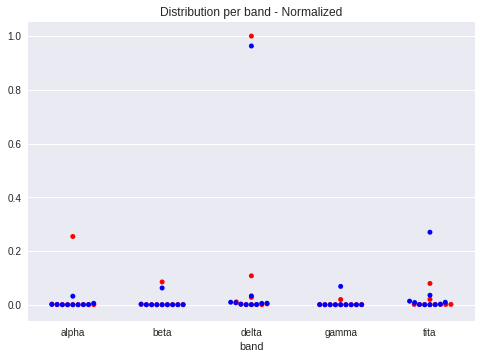

In [14]:
ax = sns.swarmplot(data=df_norm[:10],
                   color="r",
                   vmin=df_norm.min(), 
                   vmax=df_norm.max() 
                  )
ax = sns.swarmplot(data=df_norm[10:],
                   color="b",
                   vmin=df_norm.min(), 
                   vmax=df_norm.max() 
                  )
#ax.set_yscale('log')
plt.title('Distribution per band - Normalized')
plt.show()

### BoxPlot

In [ ]:
ax = sns.boxplot(data=df_norm[:10],
                   color="r",
                   vmin=df_norm.min(), 
                   vmax=df_norm.max() 
                  )
ax = sns.boxplot(data=df_norm[10:],
                   color="b",
                   vmin=df_norm.min(), 
                   vmax=df_norm.max() 
                  )
#ax.set_yscale('log')
plt.title('Distribution per band - Normalized')
plt.show()

### Point Plot

In [ ]:
ax = sns.pointplot(data=df_norm[:10],
                   color="r",
                   vmin=df_norm.min(), 
                   vmax=df_norm.max() 
                  )
ax = sns.pointplot(data=df_norm[10:],
                   color="b",
                   vmin=df_norm.min(), 
                   vmax=df_norm.max() 
                  )
#ax.set_yscale('log')
plt.title('Distribution per band - Normalized')
plt.show()

## Gráficos categóricos

Elegimos usar de ahora en adelante el violin plot, ya que da un buen resúmen de la distribución de nuestros datos para cada categoría. 

## Análisis de información (intra-electrodo)

In [31]:
from scipy.io import loadmat
import pandas as pd

import gc
gc.collect()

mat = loadmat('data/S06.mat')
panel = pd.Panel(mat['data'])
''' Item axis: Epoch
    Major axis: Electrode
    Minor axis: Sample '''
min_ = panel.min().min().min()
max_ = panel.max().max().max()
bins = np.linspace(min_, max_, 100)

print(bins)

[ -4.81029570e-04  -4.73354745e-04  -4.65679920e-04  -4.58005094e-04
  -4.50330269e-04  -4.42655444e-04  -4.34980619e-04  -4.27305793e-04
  -4.19630968e-04  -4.11956143e-04  -4.04281317e-04  -3.96606492e-04
  -3.88931667e-04  -3.81256841e-04  -3.73582016e-04  -3.65907191e-04
  -3.58232365e-04  -3.50557540e-04  -3.42882715e-04  -3.35207889e-04
  -3.27533064e-04  -3.19858239e-04  -3.12183413e-04  -3.04508588e-04
  -2.96833763e-04  -2.89158937e-04  -2.81484112e-04  -2.73809287e-04
  -2.66134462e-04  -2.58459636e-04  -2.50784811e-04  -2.43109986e-04
  -2.35435160e-04  -2.27760335e-04  -2.20085510e-04  -2.12410684e-04
  -2.04735859e-04  -1.97061034e-04  -1.89386208e-04  -1.81711383e-04
  -1.74036558e-04  -1.66361732e-04  -1.58686907e-04  -1.51012082e-04
  -1.43337256e-04  -1.35662431e-04  -1.27987606e-04  -1.20312780e-04
  -1.12637955e-04  -1.04963130e-04  -9.72883045e-05  -8.96134792e-05
  -8.19386538e-05  -7.42638285e-05  -6.65890032e-05  -5.89141779e-05
  -5.12393526e-05  -4.35645272e-05

In [65]:
# a) Computar una medida de información intra-electrodo. Calcular la media entre canales y epochs para cada sujeto. Realizar el gráfico elegido en el punto c) de la sección anterior, acompañado del test estadístico apropiado.

import scipy.stats
from collections import defaultdict
import numpy as np

import gc
gc.collect()

def compute_entropy(series):
    histogram, _ = np.histogram(series, bins)
    probabilities = [frecuency/len(series) for frecuency in histogram]
    return scipy.stats.entropy(probabilities)

def compute_entropies_for_subject(panel):
    n_epochs, n_electrodes, n_measures = panel.shape
    entropies = defaultdict(dict)
    for epoch in range(n_epochs):
        for electrode in range(n_electrodes):
            electrode_data = panel[epoch, electrode]
            entropy = compute_entropy(electrode_data)
            entropies[epoch][electrode] = entropy
    return pd.DataFrame(entropies)

(657,)


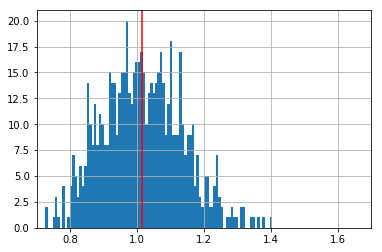

(256,)


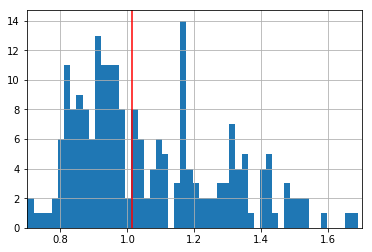

In [87]:
import matplotlib.pyplot as plt

def mean_between_epochs(df):
    return df.mean(0)
def mean_between_electrodes(df):
    return df.mean(1)

def plot_histograms_for_subject(entropies):
    # Promediamos por electrodos, obtenemos histograma por epochs
    mean_epochs = mean_between_epochs(entropies)
    print(mean_epochs.shape)
    mean_epochs.hist(bins=100)
    plt.axvline(mean_epochs.mean(), color='r')
    plt.xlim(0.7,1.7)
    plt.show()
    
    # Promediamos por epochs, obtenemos histograma por electrodos
    mean_electrodes = mean_between_electrodes(entropies)
    print(mean_electrodes.shape)
    mean_electrodes.hist(bins=100)
    plt.axvline(mean_electrodes.mean(), color='r')
    plt.xlim(0.7,1.7)
    plt.show()

def subject_global_mean(entropies):
    return entropies.mean().mean()

entropies = compute_entropies_for_subject(panel)
plot_histograms_for_subject(entropies)

In [69]:
from os import listdir
from os.path import join

files_S = [f for f in listdir('data') if (f.endswith('.mat') and f.startswith('S'))]
files_P = [f for f in listdir('data') if (f.endswith('.mat') and f.startswith('P'))]
global_means_for_S = []
global_means_for_P = []

for filename in files_S:
    mat = loadmat(join('data', filename))
    panel = pd.Panel(mat['data'])
    entropies = compute_entropies_for_subject(panel)
    global_mean = subject_global_mean(entropies)
    print("Subject: {}, Entropy: {}".format(filename, global_mean))
    global_means_for_S.append(global_mean)
    del mat
    del panel
    gc.collect()
    
for filename in files_P:
    mat = loadmat(join('data', filename))
    panel = pd.Panel(mat['data'])
    entropies = compute_entropies_for_subject(panel)
    global_mean = subject_global_mean(entropies)
    print("Subject: {}, Entropy: {}".format(filename, global_mean))
    global_means_for_P.append(global_mean)
    del mat
    del panel
    gc.collect()

Subject: S02.mat, Entropy: 1.2799294989525245


KeyboardInterrupt: 

In [ ]:
plt.hist(global_means_for_S)
plt.hist(global_means_for_P)
plt.show()

## Análisis de información (inter-electrodo)

In [76]:
import itertools
from functools import reduce

# TODO: revisar el bins global

def joint_entropy(signal_1, signal_2):
    _, bins_1 = np.histogram(signal_1, bins)
    _, bins_2 = np.histogram(signal_2, bins)
    
    signal_1 = np.digitize(signal_1, bins_1)
    signal_2 = np.digitize(signal_2, bins_2)
    
    signal = list(zip(signal_1, signal_2))
    probabilities = [signal.count(s) / len(signal) for s in signal]
    return scipy.stats.entropy(probabilities)
    

def inter_electrode_analysis(panel, epoch, electrode_1, electrode_2):
    signal_1 = panel[epoch, electrode_1]
    signal_2 = panel[epoch, electrode_2]
    return joint_entropy(signal_1, signal_2)

inter_electrode_analysis(panel, 0, 8, 24)

5.192223006127854

In [ ]:
from itertools import combinations
ALPHA_RELEVANT_ELECTRODES = [8,44,80,131,185]

def joint_entropy_for_subject(panel):
    entropies = []
    n_epochs, n_electrodes, n_measures = panel.shape
    for epoch in range(n_epochs):
        for combination in combinations(ALPHA_RELEVANT_ELECTRODES, 2):
            entropies.append(inter_electrode_analysis(panel, epoch, *combination))
    return pd.DataFrame(entropies)

def plot_histogram_for_joint_entropies(entropies):
    entropies.hist()
    plt.show()
    
def mean_of_entropies(entropies):
    return entropies.mean()

panel = pd.Panel(loadmat('data/P01.mat')['data'])
entropies = joint_entropy_for_subject(panel)
print(entropies)
plot_histograms_for_subject(entropies)
mean_of_entropies(entropies)

In [ ]:
from os import listdir
from os.path import join

files_S = [f for f in listdir('data') if (f.endswith('.mat') and f.startswith('S'))]
files_P = [f for f in listdir('data') if (f.endswith('.mat') and f.startswith('P'))]
global_means_for_S = []
global_means_for_P = []

for filename in files_S:
    mat = loadmat(join('data', filename))
    panel = pd.Panel(mat['data'])
    entropies = joint_entropy_for_subject(panel)
    global_mean = mean_of_entropies(entropies)
    print("Subject: {}, Entropy: {}".format(filename, global_mean))
    global_means_for_S.append(global_mean)
    del mat
    del panel
    gc.collect()
    
for filename in files_P:
    mat = loadmat(join('data', filename))
    panel = pd.Panel(mat['data'])
    entropies = joint_entropy_for_subject(panel)
    global_mean = mean_of_entropies(entropies)
    print("Subject: {}, Entropy: {}".format(filename, global_mean))
    global_means_for_P.append(global_mean)
    del mat
    del panel
    gc.collect()